In [9]:
import os
import numpy as np

In [6]:
actionSpotting_v2_path = '/data/kaushik3/SoccerData/ActionSpotting/ActionSpotting_v2'
resnet_features_path = '/data/kaushik3/SoccerData/ResNET_features'
baidu_features_path = '/data/kaushik3/SoccerData/Baidu_Features'

In [7]:
exists = 0
missing = 0
total = 0
for league in os.listdir(os.path.join(actionSpotting_v2_path, 'train')):
    for season in os.listdir(os.path.join(actionSpotting_v2_path, 'train', league)):
        for game in os.listdir(os.path.join(actionSpotting_v2_path, 'train', league, season)):
            feature_path = os.path.join(baidu_features_path, league, season, game)
            if not os.path.exists(feature_path):
                missing += 1
            else:
                exists += 1
            total += 1

In [8]:
print('Total:', total)
print('Exists:', exists)
print('Missing:', missing)

Total: 300
Exists: 300
Missing: 0


In [14]:
r1 = np.load('/data/kaushik3/SoccerData/ResNET_features/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/1_ResNET_TF2.npy')

In [24]:
print(r1.shape)

(5534, 2048)


In [16]:
from utils.helpers import load_json

all_labels = {}
for league in os.listdir(os.path.join(actionSpotting_v2_path, 'train')):
    for season in os.listdir(os.path.join(actionSpotting_v2_path, 'train', league)):
        for game in os.listdir(os.path.join(actionSpotting_v2_path, 'train', league, season)):
            label_path = os.path.join(actionSpotting_v2_path, 'train', league, season, game, 'Labels-v2.json')
            labels = load_json(label_path)
            for label in labels['annotations']:
                if label['label'] not in all_labels:
                    all_labels[label['label']] = 0
                all_labels[label['label']] += 1



In [17]:
all_labels_val = {}
for league in os.listdir(os.path.join(actionSpotting_v2_path, 'val')):
    for season in os.listdir(os.path.join(actionSpotting_v2_path, 'val', league)):
        for game in os.listdir(os.path.join(actionSpotting_v2_path, 'val', league, season)):
            label_path = os.path.join(actionSpotting_v2_path, 'val', league, season, game, 'Labels-v2.json')
            labels = load_json(label_path)
            for label in labels['annotations']:
                if label['label'] not in all_labels_val:
                    all_labels_val[label['label']] = 0
                all_labels_val[label['label']] += 1

In [21]:
for key in sorted(all_labels.keys()):
    print(key, all_labels[key])

Ball out of play 19097
Clearance 4749
Corner 2884
Direct free-kick 1379
Foul 7084
Goal 995
Indirect free-kick 6331
Kick-off 1516
Offside 1265
Penalty 96
Red card 34
Shots off target 3214
Shots on target 3463
Substitution 1700
Throw-in 11391
Yellow card 1238
Yellow->red card 24


In [22]:
for key in sorted(all_labels_val.keys()):
    print(key, all_labels_val[key])

Ball out of play 6253
Clearance 1516
Corner 953
Direct free-kick 439
Foul 2176
Goal 371
Indirect free-kick 1907
Kick-off 536
Offside 417
Penalty 36
Red card 13
Shots off target 984
Shots on target 1182
Substitution 560
Throw-in 3718
Yellow card 378
Yellow->red card 8


In [1]:
from utils.dataset import ActionSpotting_v2
from tqdm import tqdm
import torch 

def save_dataset(feature_path, label_path, split, save_path):
    dataset = ActionSpotting_v2(feature_path, label_path, split)

    # Convert dataset to a list of tensors
    print("\nSaving dataset...")
    data_list = [dataset[i] for i in tqdm(range(len(dataset)), desc="Saving Samples")]

    # Save as a PyTorch .pt file
    torch.save(data_list, save_path)
    print(f"Dataset saved to {save_path}")

# Define paths and save dataset
feature_path = "/data/kaushik3/SoccerData/ResNET_features"
label_path = "/data/kaushik3/SoccerData/ActionSpotting/ActionSpotting_v2"
split = "train"
video_length = 15
overlap = 5
save_path = f"/data/kaushik3/SoccerData/ResNET_features/ActionSpotting_v2_{split}_video_length_{video_length}_overlap_{overlap}.pt"

save_dataset(feature_path, label_path, split, save_path)

ImportError: cannot import name 'ActionSpotting_v2' from partially initialized module 'utils.dataset' (most likely due to a circular import) (/home/csgrad/kaushik3/DenseVideoCaptioning/ActionSpotting/utils/dataset.py)

In [15]:
import gzip
import pickle

fname  = '/home/csgrad/kaushik3/DenseVideoCaptioning/ActionSpotting/logdir/saves/36.gz'
with gzip.open(fname, 'rb') as fp:
    ckpt = pickle.load(fp)



In [16]:
from utils.evaluate import Checkpoint, Video

c = Checkpoint.load(fname)
print(c)

< Checkpoint[36] 151 videos >


In [24]:
c._random_video()[1].__dict__

{'vname': 'spain_laliga/2016-2017/2016-09-17 - 14-00 Leganes 1 - 5 Barcelona/1',
 'start_time': tensor(445),
 'end_time': tensor(460),
 'gt_label': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]),
 'pred': array([ 0,  0,  0,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15]),
 'pred_label': array([ 0,  0,  0,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15]),
 'metrics': OrderedDict([('Edit', 0.0)])}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import json
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [185]:
data = np.load('/data/kaushik3/SoccerData/ResNET_features/europe_uefa-champions-league/2014-2015/2014-11-05 - 22-45 Ajax 0 - 2 Barcelona/2_ResNET_TF2.npy')
# data = np.load('/data/kaushik3/SoccerData/Baidu_Features/europe_uefa-champions-league/2014-2015/2014-11-05 - 22-45 Ajax 0 - 2 Barcelona/1_baidu_soccer_embeddings.npy')

In [186]:
data.shape

(5400, 2048)

In [187]:
label_values = {
            'Background': 0, 'Ball out of play': 1, 'Clearance': 2, 'Corner': 3,
            'Direct free-kick': 4, 'Foul': 5, 'Goal': 6, 'Indirect free-kick': 7,
            'Kick-off': 8, 'Offside': 9, 'Penalty': 10, 'Red card': 11,
            'Shots off target': 12, 'Shots on target': 13, 'Substitution': 14,
            'Throw-in': 15, 'Yellow card': 16, 'Yellow->red card': 17
        }
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data
    
def get_gametime_half(game_time):
        return int(game_time.split()[0])

def convert_game_info_to_list(game_info, half, length_of_half):
    labels = [0] * length_of_half 
    for action in game_info['annotations']:
        if get_gametime_half(action['gameTime']) == half:
            position = int(action['position']) // 1000
            if position < length_of_half:
                labels[position] = label_values[action['label']]
            else:
                print(f"Position {position} is greater than the length of the half {length_of_half}. Defaulting to last time spot.")
                labels[-1] = label_values[action['label']]
    return labels

In [188]:
def plot(embeddings, labels):
    # labels = np.array(labels)
    # mask = labels != 0
    # embeddings = embeddings[mask, :]
    # labels = labels[mask]
    
   

    # Perform KMeans clustering (choose K based on unique labels)
    num_clusters = len(set(labels))  # Adjust to your dataset
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(embeddings)

    # Compute clustering metrics
    sil_score = silhouette_score(embeddings, cluster_assignments)
    db_score = davies_bouldin_score(embeddings, cluster_assignments)
    ch_score = calinski_harabasz_score(embeddings, cluster_assignments)

    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}")
    print(f"Calinski-Harabasz Index: {ch_score:.4f}")
    tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='pca', random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hsv", len(set(labels)))  # Generate distinct colors

    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=palette, s=100, edgecolor='k')

    # Add text labels
    for i, (x, y) in enumerate(embeddings_2d):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Embeddings with Labels")
    plt.legend(title="Classes")

    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=cluster_assignments, palette="tab10", s=100, edgecolor='k')
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization with K-Means Clusters")
    plt.legend(title="K-Means Clusters")
    plt.show()



In [189]:
json_file = load_json('/data/kaushik3/SoccerData/ActionSpotting/ActionSpotting_v2/val/europe_uefa-champions-league/2014-2015/2014-11-05 - 22-45 Ajax 0 - 2 Barcelona/Labels-v2.json')

In [190]:
labels = convert_game_info_to_list(json_file, 2, data.shape[0]//2)

Silhouette Score: 0.3457
Davies-Bouldin Index: 1.0549
Calinski-Harabasz Index: 10.0068


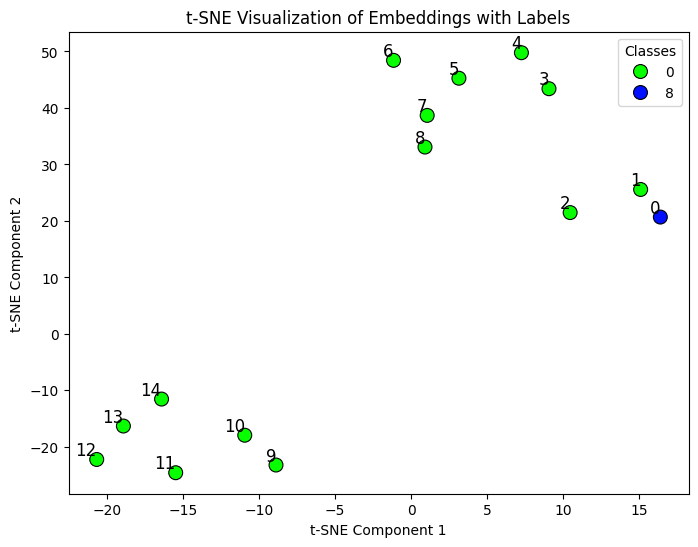

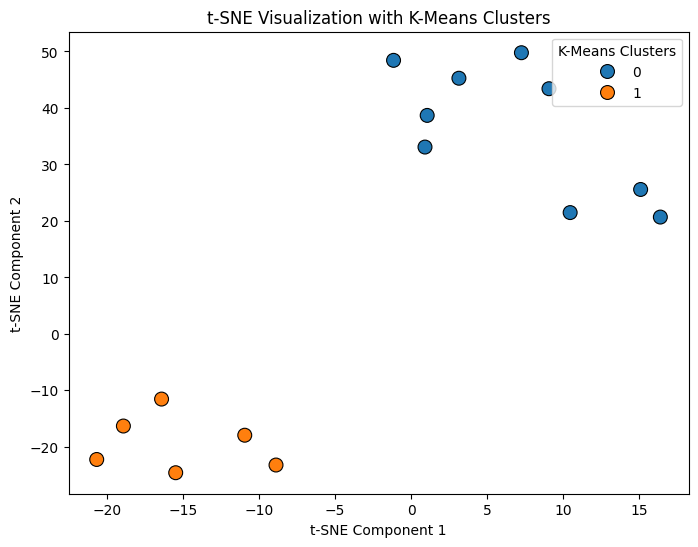

In [191]:
plot(data[:30, :][::2], labels[:15])

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import torch.nn.functional as F
import torch

def hierarchical_clustering(embeddings, labels):
    num_clusters = 1
    for i in labels:
        if i != 0:
            num_clusters += 1
    # num_clusters=len(set(labels))
    # pca = PCA(n_components=15, random_state=42)  # Reduce to 2D before clustering
    # embeddings = pca.fit_transform(embeddings)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_assignments = clustering.fit_predict(embeddings)

    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hsv", num_clusters)  # Generate distinct colors
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=labels, palette=palette, s=100, edgecolor='k')
    for i, (x, y) in enumerate(embeddings[:,  :2]):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')

    plt.xlabel("Feature Component 1")
    plt.ylabel("Feature Component 2")
    plt.title("Embeddings with True Labels")
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hsv", num_clusters)  # Generate distinct colors

    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=cluster_assignments, palette=palette, s=30, edgecolor='k')

    # Add text labels
    pts = []
    for i, (x, y) in enumerate(embeddings[:,  :2]):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        pts.append(i)

    plt.xlabel("Feature Component 1")
    plt.ylabel("Feature Component 2")
    plt.title("Hierarchical Clustering Visualization")
    plt.legend(title="Clusters")
    plt.show()
    plt.close()

    linked = linkage(embeddings, method='ward')
    plt.figure(figsize=(10, 5))
    dendrogram(linked, orientation='top', labels=pts, distance_sort='descending', show_leaf_counts=True)
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

    tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='pca', random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hsv", len(set(labels)))  # Generate distinct colors

    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=palette, s=100, edgecolor='k')

    # Add text labels
    for i, (x, y) in enumerate(embeddings_2d):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Embeddings with Labels")
    plt.legend(title="Classes")

    plt.show()
    plt.close()

    embeddings = torch.tensor(embeddings)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    for i in range(len(labels)):
        if labels[i] != 0:
            emb = embeddings[i]
            d2 = {}
            for j in range(embeddings.shape[0]):
                d2[f"{i} to {j}"] = torch.dist(emb, embeddings[j], p=2).item()  # L2 Norm
            sorted_d2 = dict(sorted(d2.items(), key=lambda item: item[1]))
            print("-" * 100)
            print("-" * 100)
            for keys, values in sorted_d2.items():
                print(keys, values)
            print("-" * 100)
            cosine = {}
            for j in range(embeddings.shape[0]):
                cosine[f"{i} to {j}"] = torch.nn.functional.cosine_similarity(emb, embeddings[j], dim=0).item()
            sorted_cosine = dict(sorted(cosine.items(), key=lambda item: item[1]))
            for keys, values in sorted_cosine.items():
                print(keys, values)

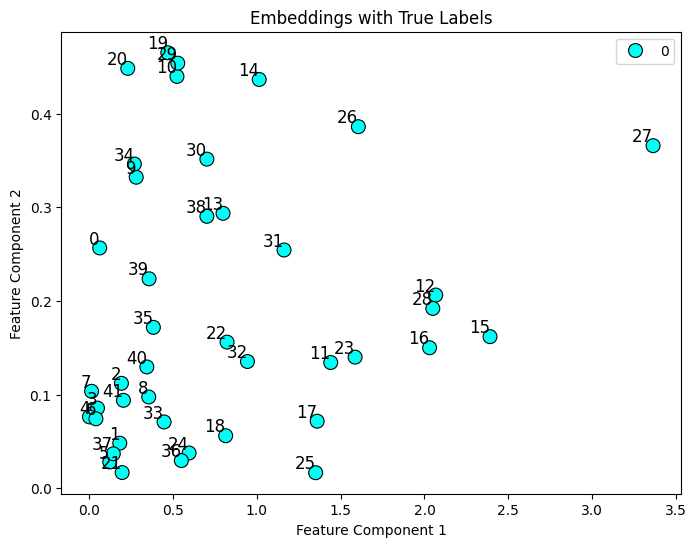

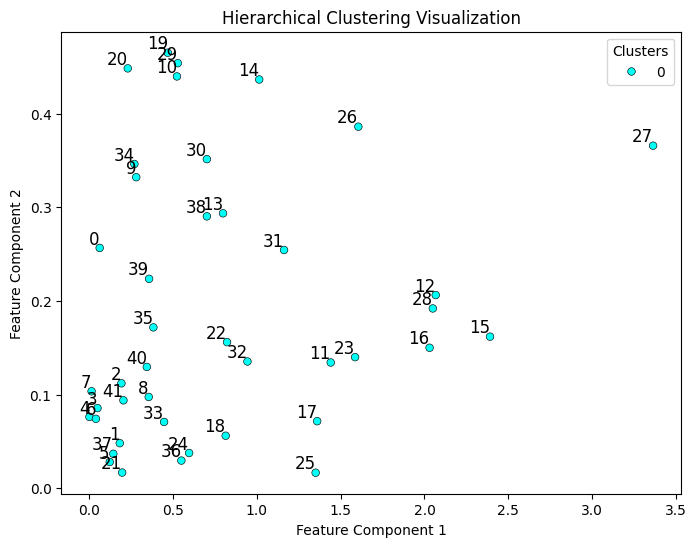

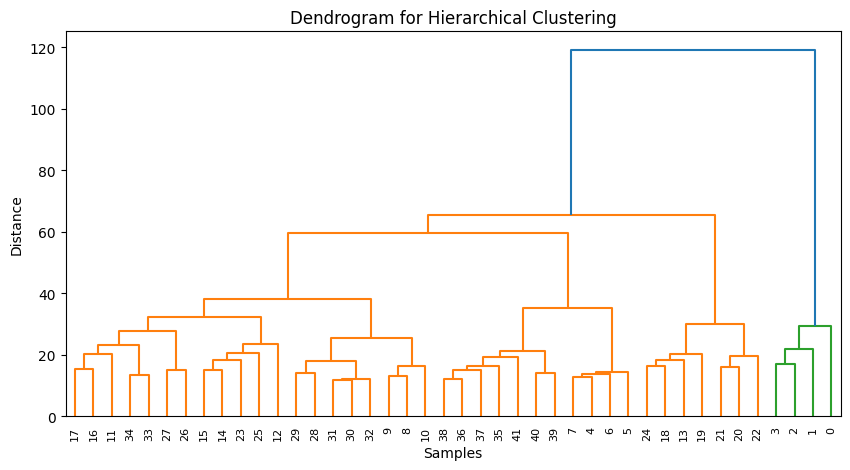

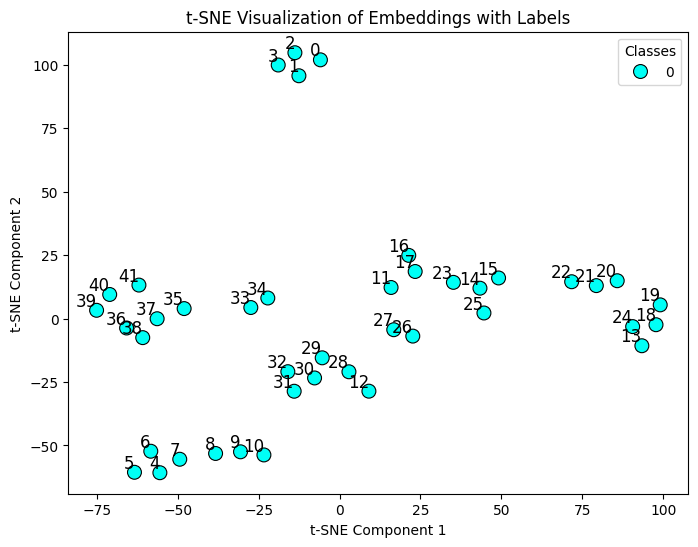

In [193]:
hierarchical_clustering(data[720:804, :][::2], labels[360:402])

In [194]:
import numpy as np
import torch
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def hybrid_distance(embeddings, alpha=0.5):
    """
    Compute a hybrid distance matrix using both cosine similarity and Euclidean distance.
    
    Args:
        embeddings (np.array): Frame embeddings (num_samples, embedding_dim)
        alpha (float): Weight factor (0 to 1). Higher = More influence of Euclidean.

    Returns:
        np.array: Hybrid distance matrix for DBSCAN
    """
    # Compute Euclidean and Cosine distance
    euclidean_dist = euclidean_distances(embeddings)
    cosine_dist = 1 - np.clip(cosine_similarity(embeddings), 0, 1)  # Convert similarity to distance
    # print(f"Cosine dist: {cosine_dist}")
    # Normalize distances (to bring them to the same scale)
    euclidean_dist /= np.max(euclidean_dist)
    cosine_dist /= np.max(cosine_dist)

    # Hybrid distance: Weighted sum of both
    hybrid_dist = alpha * euclidean_dist + (1 - alpha) * cosine_dist

    return hybrid_dist

def relabel_with_dbscan(embeddings, labels, eps=0.13, min_samples=2, metric='cosine'):
    """
    Relabels frame embeddings using DBSCAN clustering.

    Args:
        embeddings (np.array): Frame embeddings of shape (num_frames, embedding_dim)
        labels (list): Original action labels (0 = no action, 1,2 = actions)
        eps (float): DBSCAN neighborhood size (lower = stricter clustering)
        min_samples (int): Minimum samples required for a cluster
        metric (str): 'cosine' or 'euclidean' distance for DBSCAN

    Returns:
        np.array: Updated labels with propagated actions
    """
    # embeddings = np.array(embeddings)  # Ensure NumPy format
    embeddings = torch.tensor(embeddings)
    embeddings = F.normalize(embeddings, p =2, dim=1)
    embeddings = embeddings.numpy()
    labels = np.array(labels)

    # Compute similarity/distance matrix for DBSCAN
    if metric == 'cosine':
        similarity_matrix = cosine_similarity(embeddings)
        distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
        distance_matrix = np.clip(distance_matrix, 0, 1)
    elif metric == 'euclidean':
        distance_matrix = euclidean_distances(embeddings)
    elif metric == 'hybrid':
        distance_matrix = hybrid_distance(embeddings, alpha=0.67)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    cluster_labels = dbscan.fit_predict(distance_matrix)  # -1 means noise

    # Assign action labels to detected clusters
    new_labels = labels.copy()
    for cluster_id in set(cluster_labels):
        if cluster_id == -1:
            continue  # Skip noise
        cluster_indices = np.where(cluster_labels == cluster_id)[0]

        # Check if any frame in the cluster has an action label (1 or 2)
        cluster_action_labels = labels[cluster_indices]
        action_labels = cluster_action_labels[cluster_action_labels > 0]

        if len(action_labels) > 0:
            most_common_label = np.bincount(action_labels).argmax()  # Get dominant action
            new_labels[cluster_indices] = most_common_label  # Assign action to whole cluster

    return new_labels

In [195]:
print("True labels: ", np.array(labels[360:402]))
relabel_with_dbscan(data[720:804, :][::2], labels[360:402], eps = 0.175,metric='hybrid')

True labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [196]:
for i in range(len(labels)):
    if labels[i]== 14:
        print(i)

1003
1606
1753
2045
2074
2257


In [61]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from tqdm import tqdm

path = "/data/kaushik3/SoccerData/ActionSpotting/ActionSpotting_v2/train"
feat_path = "/data/kaushik3/SoccerData/ResNET_features"
save_path = "/data/kaushik3/SoccerData/ActionSpotting/ActionSpotting_v2_segments"

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def pick_st_end(half, position, label, euclidean_thresh=0.3, cosine_thresh=0.96):
    window = {
        'Ball out of play': (-2, 2), 
        'Clearance': (-6, 2), 
        'Corner': (-6, 2),
        'Direct free-kick': (-1, 5), 
        'Foul': (-1, 4), 
        'Goal': (-2, 5), 
        'Indirect free-kick': (-1, 5),
        'Kick-off': (0, 2), 
        'Offside': (-1, 4), 
        'Penalty': (-3, 2), 
        'Red card': (-2, 1),
        'Shots off target': (-1, 3), 
        'Shots on target': (-1, 3),
        'Substitution': (-4, 1),
        'Throw-in': (-7, 2), 
        'Yellow card': (-1, 1), 
        'Yellow->red card': (-1, 1)
    }
    st, end = window[label]
    if position + st < 0:
        st = -position
    if position + end + 1 > len(half):
        embeddings =  half[position + st : ]
    else:
        embeddings =  half[position + st : position + end + 1]
    
    if embeddings.shape[0] == 0:
        return position, position
    embeddings = torch.tensor(embeddings)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    embeddings = embeddings.numpy()

    print(half.shape, position, label, embeddings.shape)
    if abs(st) >= embeddings.shape[0]:
        st = -(embeddings.shape[0] - 1)
    query_emb = embeddings[abs(st)].reshape(1, -1)
    euclidean_dist = euclidean_distances(query_emb, embeddings)[0]  # Shape (15,)
    cosine_sim = cosine_similarity(query_emb, embeddings)[0]

    euclidean_mask = euclidean_dist < euclidean_thresh
    cosine_mask = cosine_sim > cosine_thresh

    # Step 2: Create a boolean mask for selected indices
    selected_mask = euclidean_mask & cosine_mask

    # Step 3: Extract indices where the mask is True
    selected_indices = np.where(selected_mask)[0]
    # ind_list = selected_indices.tolist()
    # ind_list.sort()

    # base_id = abs(st)
    # st_ind = ind_list[0]
    # end_ind = st_ind
    # segment = (st_ind, end_ind)
    # length = 0
    # for i in range(1, len(ind_list)):
    #     if ind_list[i] - end_ind == 1:
    #         end_ind = ind_list[i]
    #     else:
    #         if base_id >= st_ind and base_id <= end_ind:
    #             if length <= end_ind - st_ind + 1:
    #                 length = end_ind - st_ind + 1
    #                 segment = (st_ind, end_ind)
    #         st_ind = ind_list[i]
    #         end_ind = st_ind
    # if segment == (ind_list[0], ind_list[0]):
    #     segment = (ind_list[0], ind_list[-1])
    # return segment[0] + position + st, segment[1] + position + st
    if label == 'Goal':
        return int(selected_indices.min()) + position + st, position + 5
    return int(selected_indices.min()) + position + st, int(selected_indices.max()) + position + st

def add_segments(data, half1, half2):
    annot = data['annotations']
    for action in annot:
        # if action['visibility'] == 'not shown':
        #     continue
        half = int(action['gameTime'].split()[0])
        position =  int(action['position']) // 1000
        if half == 1:
            st, end = pick_st_end(half1, position, action['label'])
        else:
            st, end = pick_st_end(half2, position, action['label'])
        action['start'] = st
        action['end'] = end
    return data

            

In [62]:
leagues = os.listdir(path)
for league in leagues:
    seasons = os.listdir(os.path.join(path, league))    
    for season in seasons:
        games = os.listdir(os.path.join(path, league, season))        
        for game in games:
            print(league, season, game)
            label_file = os.path.join(path, league, season, game, 'Labels-v2.json')
            half1 = np.load(os.path.join(feat_path, league, season, game, '1_ResNET_TF2.npy'))[::2, :]
            half2 = np.load(os.path.join(feat_path, league, season, game, '2_ResNET_TF2.npy'))[::2, :]
            data = load_json(label_file)
            data_segments = add_segments(data, half1, half2)
            save_file = os.path.join(save_path, path.split('/')[-1], league, season, game, 'Labels-v2_segments.json')
            os.makedirs(os.path.dirname(save_file), exist_ok=True)
            with open(save_file, 'w') as f:
                json.dump(data_segments, f, indent=4)

italy_serie-a 2015-2016 2015-09-20 - 13-30 Chievo 0 - 1 Inter
(2700, 2048) 0 Kick-off (3, 2048)
(2700, 2048) 101 Ball out of play (5, 2048)
(2700, 2048) 108 Throw-in (10, 2048)
(2700, 2048) 119 Shots on target (5, 2048)
(2700, 2048) 192 Ball out of play (5, 2048)
(2700, 2048) 216 Clearance (9, 2048)
(2700, 2048) 233 Shots on target (5, 2048)
(2700, 2048) 287 Ball out of play (5, 2048)
(2700, 2048) 291 Throw-in (10, 2048)
(2700, 2048) 324 Ball out of play (5, 2048)
(2700, 2048) 330 Throw-in (10, 2048)
(2700, 2048) 358 Foul (6, 2048)
(2700, 2048) 393 Direct free-kick (7, 2048)
(2700, 2048) 396 Ball out of play (5, 2048)
(2700, 2048) 431 Corner (9, 2048)
(2700, 2048) 439 Shots off target (5, 2048)
(2700, 2048) 443 Offside (6, 2048)
(2700, 2048) 455 Indirect free-kick (7, 2048)
(2700, 2048) 499 Ball out of play (5, 2048)
(2700, 2048) 503 Throw-in (10, 2048)
(2700, 2048) 532 Foul (6, 2048)
(2700, 2048) 608 Shots on target (5, 2048)
(2700, 2048) 608 Direct free-kick (7, 2048)
(2700, 2048) 61